<a href="https://colab.research.google.com/github/DonErnesto/masterclassSFI_2021/blob/main/notebooks/CreditCardUnsupervised.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fraud Detection with Unsupervised Outlier Detection


## Introduction 

The purpose of this Jupyter notebook is to take you through several unsupervised outlier detection algorithms, and show their value for the purpose of fraud detection. The completely different situation compared to the supervised case, is that we -assume to- have no or too few labels to learn from. This is typically the case in fraud detection, as fraudulent events are often very rare. In applying an outlier detection for fraud detection, we hypothesize that payment patterns that are "untypical" (i.e., outliers) are more likely to be fraudulent.  

Generally, an unsupervised approach is taken only when there are no or too few labels available. For this masterclass, we do use a dataset that was labeled, but will not make use of those labels until after we made predictions to get a feeling of how the various algorithms perform and compare. 

The data is taken from https://www.kaggle.com/mlg-ulb/creditcardfraud, and has been downsampled for the purpose of this masterclass. 

Note that there are two types of cells in this notebook: **markdown cells** (that contain text, like this one), and **code cells** (that execute some code, like the next cell). 

In [ ]:
## Data import from Github
import os
if not os.path.exists('X_unsupervised.csv.zip'):
    !curl -O https://raw.githubusercontent.com/DonErnesto/masterclassSFI_2021/main/data/X_unsupervised.csv.zip

We will be using the `pandas` package for data handling and manipulation, and later `scikit-learn` (imported with "sklearn") and `pyod` to obtain outlier detection algorithms. 

In [65]:
import warnings
warnings.filterwarnings("ignore")

import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# A small hack: "monkey-patching" the DataFrame class to add column-wise normalization as a method
def normalize_columns(self,):
    return (self - self.mean()) / self.std()
pd.DataFrame.normalize_columns = normalize_columns

Next, we will load the data in a so-called DataFrame (with is a pandas object, and works much like an Excel sheet), and inspect it by plotting the first rows. 

We call the dataframe `X`, und use the DataFrames method `.head(n)` to display the top n rows (per default, n=5). 

In [32]:
X = pd.read_csv('X_unsupervised.csv.zip')
X.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
0,0.0,-0.7200,0.1262,-0.2262,-0.7573,0.2147,0.3516,1.4450,-0.6830,-0.5464,...,-0.0378,-0.3525,0.6494,-1.0810,-0.39230,-0.14340,-0.6920,0.8833,-0.210200,5.46
1,0.0,-1.4110,0.3550,-1.0470,0.9326,-1.4970,0.3967,-1.4750,1.0490,-1.7940,...,-0.4248,-0.3650,0.9517,0.5230,0.10830,-0.13880,2.5820,-0.3887,0.009520,52.53
2,1.0,0.4917,-1.4040,1.0270,0.9020,-0.7363,-0.3188,0.2524,-2.0230,0.4365,...,-1.0470,-0.7330,-0.1733,1.0900,0.56400,-0.55700,-0.0928,1.5810,-0.005043,22.48
3,1.0,-1.2430,0.2893,-0.7030,0.7340,-0.1942,0.4436,0.3428,-0.1865,-0.1589,...,-2.2770,0.4973,0.7670,-0.3362,-0.00434,0.02498,0.7993,0.4668,0.074460,15.00
4,2.0,0.2642,0.7010,1.5230,-1.4570,-0.3555,1.1720,-0.7266,-1.4990,-0.5590,...,-1.3620,0.5350,-2.4450,1.5910,0.87200,-0.67870,0.9653,0.1272,0.132400,237.00


In [ ]:
print(f'The data has {len(X)} rows and {len(X.columns)} columns')

The data describes credit card transactions, one transaction per row. There are 30'000 rows, with 30 columns. 

As you see, all features are numeric. The `Vx` features are the result of a mathematical operation called PCA. In reality we are often dealing with non-numerical data (text, categories, ...), that require some effort to be converted to numerical, making it suitable for the mathematical models we work with. Not having to deal with that complexity right now, we can save some time. 


## In-class example: home-made outlier scores on two columns of X

To demonstrate elementary data-wrangling functions in pandas and to demonstrate the workflow of the break-out sessions, we will look at a subset of the full dataset and hand-craft outlier scores that we will evaluate. 



In [60]:
# Make a new dataset that consists of two select columns from the full dataset
# use .loc[] two subset the DataFrame
# We call this new DataFrame X_2cols
X_2cols = X.loc[:, ['V2', 'Amount']]

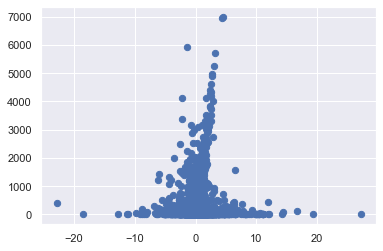

In [57]:
# We can visualize this 2-D dataset in a scatterplot
plt.scatter(X_2cols['V2'], X_2cols['Amount'], s=40, cmap='viridis');

In this 2-dimensional dataset we see some obvious outliers. Let's calculate outlier scores ourselves and evaluate the results visually. Before doing so, let's look at some elementary operations on DataFrames

Some methods we can use on DataFrames are:

- `.abs()` This method converts all values to absolute (and does not change the size of the DataFrame)
- `.drop(columns=...)` This method drops the indicated columns (may be a string or a list of strings) 
- `.max(axis=1)` This method, when executed with axis=1, sums over all columns
- `.mean(axis=1)` This method, with axis=1, takes the means over all columns 

Note that each of these methods return again a DataFrame. They may thus be executed one after the other (this is called "method chaining" in Python). 

In [70]:
# Let's look at the original data, and what the operations do to it. 
# We only look at the first 5 rows (hence the .head() method at the end)
display(X_2cols.head()) # original data
display(X_2cols.abs().head()) # converted to absolute values
display(X_2cols.normalize_columns().head()) # normalized columns: 0 mean and 1 variance
display(X_2cols.max(axis=1).head()) # the row-wise maximum of the two columns

,V2,Amount
0,0.1262,5.46
1,0.3550,52.53
2,-1.4040,22.48
3,0.2893,15.00
4,0.7010,237.00


,V2,Amount
0,0.1262,5.46
1,0.3550,52.53
2,1.4040,22.48
3,0.2893,15.00
4,0.7010,237.00


,V2,Amount
0,0.171434,-0.348701
1,0.483451,-0.153090
2,-1.915313,-0.277970
3,0.393855,-0.309055
4,0.955294,0.613521


0      5.46
1     52.53
2     22.48
3     15.00
4    237.00
dtype: float64

The last result is a pd.Series (which is why it is displayed differently), which is a 1-D data structure. This is the form we need for our homemade outlier score: one score per row. 

In [84]:
# Some examples to make an outlier score below. Uncomment (remove the "#") to execute it.

# homemade_outlier_scores = X_2cols.abs().max(axis=1)
# homemade_outlier_scores = (X_2cols.normalize_columns()**2).mean(axis=1)
# homemade_outlier_scores = X_2cols['Amount']
# homemade_outlier_scores = (X_2cols.normalize_columns()**2).max(axis=1)


**Question**: Which of the scores above would you choose? Why?

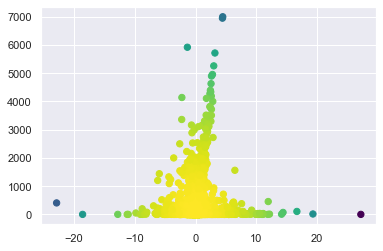

In [85]:
plt.scatter(X_2cols['V2'], X_2cols['Amount'], c=homemade_outlier_scores, s=40, cmap='viridis_r');

Finally, we evaluate the scores in the Evaluation section at the very end. Note that in the break-out session, the evaluation should also be done at the very end, i.e., no "peaking" at the solution. 


# Break-out session

First run the cells below for important imports and to remove the "Time" column.

Then go to the section of the outlier algorithm assigned to you or chosen by you below to generate your scores. Answer the questions belonging to your algorithm, and compare the results with those of your home-made algorithm (see section `Evaluation`)


In [18]:
from sklearn.covariance import EmpiricalCovariance
from sklearn.neighbors import NearestNeighbors
from sklearn.ensemble import IsolationForest
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import MinMaxScaler

try:
    import pyod
except ModuleNotFoundError:
    !pip install pyod
from pyod.models.auto_encoder import AutoEncoder

In [ ]:
# We consider Time to be not meaningful for outlier detection
X = X.drop(columns='Time')

## Outlier algorithms


### Mahalanobis Distance

The Mahalanobis distance is a generalization of distance (measured in standard deviations) to a multivariate normal distribution. The assumption being made is thus that the data is normally distributed, and that outliers are located further away from the center than the inliers. 

Run the cells below to: 
- Create an EmpiricalCovariance object
- Fit the data to this model
- Assign the scores to `mah_outlier_scores`, using the method `.mahalanobis()`, applied on the fitted object `cov`

If necessary, add a `-` after the equals sign of the assignment (remember, we want outlier scores to be large for outliers). 

In [ ]:
?EmpiricalCovariance

In [ ]:
cov = EmpiricalCovariance()
cov.fit(X)

# cov is now an EmpiricalCovariance object that is fitted on the data X. 
# assign the mahalanobis scores using its .mahalanobis() method

# mah_outlier_scores =  

In [ ]:
# inspect the documentation to determine the correct sign for the scoring
?cov.mahalanobis

**Question**: in which situation is the ranking by a Mahalonobis-distance score equivalent by a ranking based on a column-wise sum of squared values? In this case, is this so? 

*Hint*: You may use `.std()` on X the get the standard deviations along its 30 dimensions

### Gaussian Mixture

The Gaussian Mixture is a assumes the data consists of one or multiple "blobs" of clusters with some normal distribution (NB: with a co-variance matrix constrained to be spherical, diagonal or non-constrained - full). It is a "soft clustering" method, as each point may belong to each cluster with some probability. 
After fitting, the method .score_samples() returns some probability measure (probability density of the point within the gaussian mixture distribution). 

Run the cells below to: 

- Create a GaussianMixture object (you may adapt the parameters if desired)
- Fit the object to the data
- Get scores for the individual data points using `.score_samples()`

If necessary, add a `-` after the equals sign of the assignment (remember, we want outlier scores to be large for outliers, read the documentation to decide this). 

In [ ]:
?GaussianMixture

In [ ]:
gmm = GaussianMixture(n_components=5, covariance_type='spherical', random_state=1, n_init=3) 
gmm.fit(X)

In [ ]:
# gmm is now an GaussianMixture object that is fitted on the data X. 
# assign the scores using its .score_samples() method, and argument X

# gmm_scores = ... 


In [ ]:
?gmm.score_samples

**Question**: It is not trivial to know in advance a good value for the number of components. Can you think of a procedure to estimate it?


### Nearest neighbours

Neighbourhood-based algorithms look at the distances to a point's neighbours to determine its "outlierness". 
In the most basic NearestNeighbor algorithm as used here, the distance of a point to its neighbours is used to measure its outlierness. (The more involved LOF algorithm uses the deviation in local density of a data point with respect to its neighbors). 

Run the cells below to: 
- Create a NearestNeighbors object (adapt the parameters if you wish)
- Fit the data to this model
- Assign the scores to `knn_outlier_scores`, by aggregating the data in `distances_to_neighbors`


Let's create a NearestNeighbors object, and use that. First, we may want to read some documentation regarding the NearestNeighbors class:

In [ ]:
?NearestNeighbors

In [ ]:
nn = NearestNeighbors(n_neighbors=50)
nn.fit(X)

# Use the .kneighbors()[0] method to get the distances in the next line
# distances_to_neighbors =   

The "heavy lifting" was done by the `.kneighbors()` method. 
It returns for each point the distances to the nearest N points, and the index of the nearest point. 

As a final step, we collapse this distance matrix (m points x N neighbours) to m scores. This may be done in several ways, for instance by taking the mean, or the median. Choose one of the options given below (by default, the mean is taken). 

In [ ]:
?nn.kneighbors

In [ ]:
# knn_outlier_scores = np.mean(distances_to_neighbors, axis=1)
# knn_outlier_scores = np.median(distances_to_neighbors, axis=1)
# knn_outlier_scores = np.max(distances_to_neighbors, axis=1)
# knn_outlier_scores = np.min(distances_to_neighbors, axis=1)


**Question**: what is an interpretation (say when n_neighbours is 11) for the

- median
- min
- max

distance to the n_neighbours? 
Why would you prefer one over the other?

### Isolation Forest algorithm

The isolation forest algorithm measures how difficult it is to isolate a point from the rest of the data, using a random splitting algorithm. Similar to the Random Forest algorithm, many (`n_estimators`) different trees are built, each time based on a randomly drawn sample (of size `max_samples`).

Run the cells below to: 
- Create an IsolationForest object with the correct parameters
- Fit the IsolationForest object with the data
- Get the scores using `.score_samples()`

If necessary, add a `-` after the equals sign of the assignment (remember, we want outlier scores to be large for outliers. Read the documentation, and note that the score as returned by `.score_samples()` is a measure for the number of needed splits to isolate a point). 

In [ ]:
?IsolationForest

In [ ]:
iforest = IsolationForest(n_estimators=100, max_samples=1024, random_state=24)
iforest.fit(X)


In [ ]:
# Assign the scores to the variable iforest_outlier_scores using the method .score_samples(),
# giving X as an argument, taking into account the correct sign. 
# iforest_outlier_scores = ... 

In [ ]:
?iforest.score_samples

**Question:** 

What advantage and disadvantage of this method do you see?


###  Autoencoder

Autoencoders are a special type of neural networks, that are trained to effectively compress and decompress a signal. The idea behind using these networks for outlier detection, is that the neural network is expected to handle "typical" datapoints well, whereas it will struggle with outliers. 

We use the pyod `AutoEncoder` class to construct the network. This way we don't have to bother with the details of building the network, and can focus on the main parameters. 

Run the cells below to: 
- Create an Autoencoder object
- Train this object on the data
- Get the scores using .score_samples()


In [ ]:
?AutoEncoder

In [ ]:
?MinMaxScaler

In [ ]:
X_scaled = MinMaxScaler().fit_transform(X)
clf = AutoEncoder(
    hidden_neurons=[10, 5, 10], # Choose bottleneck here!
    hidden_activation='elu',
    output_activation='sigmoid', 
    optimizer='adam',
    epochs=10,
    batch_size=16,
    dropout_rate=0.0, #may not be needed here
    l2_regularizer=0.0,
    validation_size=0.1,
    preprocessing=False, #NB: this uses sklearn's StandardScaler
    verbose=1,
    random_state=1,
)

In [ ]:
clf.fit(X_scaled)

In [ ]:
?AutoEncoder

If necessary, add a `-` after the equals sign of the assignment (remember, we want outlier scores to be large for outliers. Read the documentation of `AutoEncoder`, especially regarding the attribute `decision_scores_`)

In [ ]:
# Assign scores to the variable autoenc_outlier_scores, using the `clf.decision_scores_` attribute 
# NB: this is not a method, and does therefore not need to be called with `()`
# autoenc_outlier_scores = ...

**Question**: Why do you think we had to scale the data with a MinMaxScaler (hint: the signal needs to be reconstructed by the network). 


## Evaluation

In the next section, you will compare how your algorithm did against your "home-made" algorithm, using the labels (ground-truth: is a point an outlier or not? In this case: is a transaction fraudulent or not?). 
Note that this information is usually not available for those problems where we decide to use outlier detection.


Look carefully at the plots and assess their meaning. 



In [89]:
# Get the labels, and a helper module
import os
import pandas as pd
force_download = False
if force_download or not os.path.exists('y_unsupervised.csv.zip'): # then probably nothing was downloaded yet
    !curl -O https://raw.githubusercontent.com/DonErnesto/masterclassSFI_2021/main/data/y_unsupervised.csv.zip
if True or not os.path.exists('outlierutils.py'):
    !curl -O https://raw.githubusercontent.com/DonErnesto/masterclassSFI_2021/main/outlierutils.py
        
y = pd.read_csv('y_unsupervised.csv.zip')['Class']


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 13595  100 13595    0     0  36253      0 --:--:-- --:--:-- --:--:-- 36156


In [ ]:
from outlierutils import plot_top_N as ptn, plot_outlier_scores

In [87]:
from sklearn.metrics import roc_auc_score, plot_roc_curve, plot_precision_recall_curve, average_precision_score

In [90]:
plot_roc_curve(y, homemade_outlier_scores)

TypeError: plot_roc_curve() missing 1 required positional argument: 'y'

In [116]:

fpr, tpr, _ = roc_curve(y, homemade_outlier_scores)
roc_auc = auc(fpr, tpr)


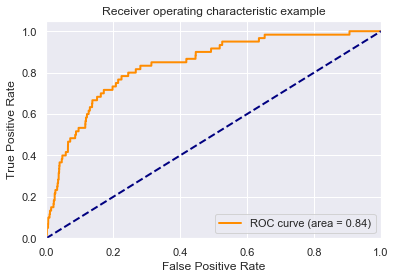

In [105]:
plt.figure()
lw = 2
plt.plot(
    fpr,
    tpr,
    color="darkorange",
    lw=lw,
    label="ROC curve (area = %0.2f)" % roc_auc,
)
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic example")
plt.legend(loc="lower right")
plt.show()



In [135]:
from sklearn.metrics import roc_curve, precision_recall_curve, auc, average_precision_score

def plot_roc_averageprecision_curves(y_true, y_pred):
    fpr, tpr, _ = roc_curve(y, homemade_outlier_scores)
    prec, recall, _ = precision_recall_curve(y, homemade_outlier_scores, pos_label=1)

    roc_auc = auc(fpr, tpr)
    ap = average_precision_score(y, homemade_outlier_scores)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

    ax1.plot(
        fpr,
        tpr,
        color="darkorange",
        lw=lw,
        label="ROC curve")
    ax1.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
    ax1.set_xlim([0.0, 1.0])
    ax1.set_ylim([0.0, 1.05])
    ax1.set_xlabel("False Positive Rate", fontsize=14)
    ax1.set_ylabel("True Positive Rate", fontsize=14)
    ax1.set_title(f"ROC curve (AUC = {roc_auc:.2f})", fontsize=15)
    ax1.legend(loc="lower right")

    ax2.plot(
        recall,
        prec,
        color="darkorange",
        lw=lw,
        label="Precision-recall curve")
    ax2.set_xlim([0.0, 1.0])
    ax2.set_ylim([0.0, 1.05])
    ax2.set_xlabel("True Positive Rate (Recall)", fontsize=14)
    ax2.set_ylabel("Precision", fontsize=14)
    ax2.set_title(f"AP curve (AUC = {ap:.2f})", fontsize=15)
    ax2.legend(loc="lower right")
    plt.display()



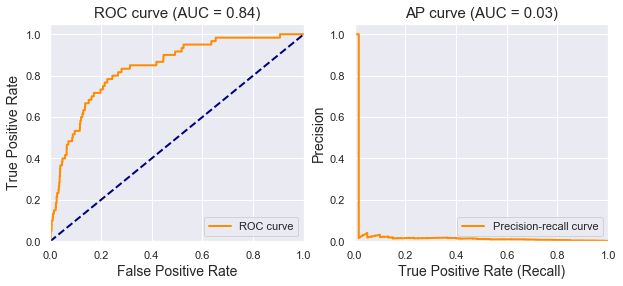

In [136]:
plot_roc_averageprecision_curves(y, homemade_outlier_scores)

### Conditional distributions of the scores, and the AUC metrics

NB: 
- plot your "homemade" score and your own algorithm
- use np.log1p(your_score) to logtransform your score if needed (in case it has a very long "tail")
- if a variable name has a red squiggle underneath, it means that the variable doesn't exist. Executing a cell containing such a missing variable will result in a NameError


In [ ]:
 _ = plot_outlier_scores(y.values, np.log1p(homemade_outlier_scores), title='Homemade: ')

In [ ]:
_ = plot_outlier_scores(y.values, np.log1p(mah_outlier_scores), title='Mahalonobis: ')

In [ ]:
_ = plot_outlier_scores(y.values, gmm_scores - min(gmm_scores), title='GMM: ')

In [ ]:
_ = plot_outlier_scores(y.values, np.log1p(knn_outlier_scores), title='KNN: ')

In [ ]:
_ = plot_outlier_scores(y.values, iforest_outlier_scores, title='Isolation Forest: ')

In [ ]:
_ = plot_outlier_scores(y.values, autoenc_outlier_scores, title='Autoencoder: ')

### Precision@top-N

The following plots shows how many of the top-N points in terms of score were actual outliers (the more yellow the plot, the better the algorithm performed).


In [ ]:
_ = plot_top_N(y_true=y, scores=homemade_outlier_scores, N=100)

In [ ]:
_ = plot_top_N(y_true=y, scores=mah_outlier_scores, N=100)

In [ ]:
_ = plot_top_N(y_true=y, scores=gmm_scores, N=100)

In [ ]:
_ = plot_top_N(y_true=y, scores=knn_outlier_scores, N=100)

In [ ]:
_ = plot_top_N(y_true=y, scores=iforest_outlier_scores, N=100)

In [ ]:
_ = plot_top_N(y_true=y, scores=autoenc_outlier_scores, N=100)

# Discussion

- Which home-made outlier model did you choose and why?
- How did it perform?
- What choices did you make for the outlier algorithm, if any, and why?
- How did it perform, also relative to the home-made model?
- Answers to the algorithm-specific questions
